# Elastic Metric for Cell Boundary Analysis

## Notebook setup

In [1]:
import os
import subprocess
import geomstats.backend as gs

geomstats_gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)
os.chdir(geomstats_gitroot_path[:-1])
print("Working directory: ", os.getcwd())

import warnings
warnings.filterwarnings("ignore")

import sys
sys_dir = os.path.dirname(os.getcwd()
                          )
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)

INFO: Using numpy backend


Working directory:  /home/wanxinli/dyn
Directory added to path:  /home/wanxinli


## Standard imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
from scipy import stats

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

from scipy.optimize import linear_sum_assignment as linear_assignment
from sklearn import manifold
from joblib import Parallel, delayed
from numba import jit, njit, prange

## Project-specific imports

In [4]:
from geomstats.geometry.euclidean import Euclidean
from geomstats.geometry.discrete_curves import R2, DiscreteCurves, ClosedDiscreteCurves

from geomstats.learning.frechet_mean import FrechetMean
from geomstats.learning.kmeans import RiemannianKMeans
from geomstats.learning.mdm import RiemannianMinimumDistanceToMeanClassifier
from geomstats.learning.pca import TangentPCA

import dyn.dyn.datasets.experimental as experimental
import dyn.dyn.features.basic as basic
import dyn.viz as viz

viz.init_matplotlib()
%config InlineBackend.figure_formats = ['svg']

We import the space of curves shapes equipped with different elastic metrics:
- the square root velocity metric (SRV), which is the canonical elastic metrics,
- the generalized elastic metric with parameters a, b.

# Load the dataset of interest

We load an experimental cell dataset with `n_cells` and `n_sampling_points` sampled along the boundary of each cell. 

For faster notebook execution, use small value for `n_cells` and `n_sampling_points`.

In [44]:
dataset_name = "osteosarcoma"  # "osteosarcoma" #  "retinal"
# dataset_name = "retinal"
assert dataset_name in ["osteosarcoma", "retinal"]
cell_type = "dunn"

if dataset_name == "osteosarcoma":
    n_cells = 650
    n_sampling_points = 100
    labels_a_name = "lines"
    labels_b_name = "mutations"
elif dataset_name == "retinal":
    # n_cells = 3871
    # n_sampling_points = 100
    n_cells = 100
    n_sampling_points = 10
    labels_a_name = "surfaces"
    labels_b_name = "mutations"

quotient = ["rotation"]

SAVEFIG = True
if SAVEFIG:
    figs_dir = os.path.join(os.getcwd(), f"dyn/saved_figs/{dataset_name}")
    print(f"Will save figs to {figs_dir}")
    from datetime import datetime

    now = datetime.now().strftime("%Y%m%d_%H:%M:%S")
    print(now)

Will save figs to /home/wanxinli/dyn/dyn/saved_figs/osteosarcoma
20230216_19:19:59


The variable `quotient` is used to define what is called a `cell_shape`.
- `cells`: has only removed the effect of the translation
- `cell_shapes`: additionally removes what is written in `quotient`: the effect of the scaling, and of the rotation.

Note: in the previous analysis, we were using the linear euclidean metric on cells (without translation), and the srv metric on cell shapes (without translation, scaling and rotation).

This notebook compares the linear versus the srv metric on data on which the same preprocessing has been performed.

In [6]:
if dataset_name == "osteosarcoma":
    cells, cell_shapes, labels_a, labels_b = experimental.load_treated_osteosarcoma_cells(
        n_cells=n_cells, n_sampling_points=n_sampling_points, quotient=quotient
    )
    
else:
    cells, cell_shapes, labels_a, labels_b = experimental.load_mutated_retinal_cells(
        n_cells=n_cells, n_sampling_points=n_sampling_points, quotient=quotient
    )

... Selecting only a random subset of 650 / 650 cells.
... Interpolating: Cell boundaries have 100 samplings points.
... Removing potential duplicate sampling points on cell boundaries.

- Cells: quotienting translation.
- Cell shapes: quotienting rotation.


In [7]:
# do_not_quotient = False
# if do_not_quotient:
#     cell_shapes = cells

# Preprocessing

# Remove dlm8 cells


In [8]:
def remove_cells(cells, cell_shapes, labels_a, labels_b, delete_indices):
    """ 
    Remove cells of control group from cells, cell_shapes, labels_a, labels_b,
    the parameters returned from load_treated_osteosarcoma_cells
    Also update n_cells

    :param list[int] delete_indices: the indices to delete
    """
    
    # Delete elements
    cells = np.delete(np.array(cells), delete_indices, axis=0)
    cell_shapes = np.delete(np.array(cell_shapes), delete_indices, axis=0)
    labels_a = list(np.delete(np.array(labels_a), delete_indices, axis=0))
    labels_b = list(np.delete(np.array(labels_b), delete_indices, axis=0))
    global n_cells
    n_cells = cells.shape[0]

    return cells, cell_shapes, labels_a, labels_b

In [9]:
# Find all dlm8 cells
dlm8_indices = []
for i in range(len(labels_a)):
    if labels_a[i] == "dlm8":
        dlm8_indices.append(i)

# Delete all dlm8 cells
cells, cell_shapes, labels_a, labels_b = remove_cells(cells, cell_shapes, labels_a, labels_b, dlm8_indices)

## Remove outliers by DeCOr-MDS using linear metric

In [10]:
""" 
Remove only abnormal outliers
"""

# Find indices for cells that are dlm8

abnormal_outlier_indices = [89]

cells, cell_shapes, labels_a, labels_b = remove_cells(cells, cell_shapes, labels_a, labels_b, abnormal_outlier_indices)

In [11]:
print("cells shape is:", cells.shape)
print("cell_shapes shape is:", cell_shapes.shape)
print("labels_a shape is:", len(labels_a))
print("labels_b shape is:", len(labels_b))
print("n_cells is:", n_cells)

cells shape is: (391, 100, 2)
cell_shapes shape is: (391, 100, 2)
labels_a shape is: 391
labels_b shape is: 391
n_cells is: 391


In [12]:
labels_a_dict = {lab: i_lab for i_lab, lab in enumerate(np.unique(labels_a))}
labels_b_dict = {lab: i_lab for i_lab, lab in enumerate(np.unique(labels_b))}

print(f"Dictionary associated to label \"{labels_a_name}\":")
print(labels_a_dict)
print(f"Dictionary associated to label \"{labels_b_name}\":")
print(labels_b_dict)

Dictionary associated to label "lines":
{'dunn': 0}
Dictionary associated to label "mutations":
{'control': 0, 'cytd': 1, 'jasp': 2}


## Define Shape Spaces

In [13]:
R1 = Euclidean(dim=1)
CLOSED_CURVES_SPACE = ClosedDiscreteCurves(R2)
CURVES_SPACE = DiscreteCurves(R2)
SRV_METRIC = CURVES_SPACE.srv_metric
L2_METRIC = CURVES_SPACE.l2_curves_metric

ELASTIC_METRIC = {}
METRICS = {}
METRICS["Linear"] = L2_METRIC
METRICS["SRV"] = SRV_METRIC

# Sample Means

We compare results when computing the mean cell versus the mean cell shapes with different elastic metrics.

In [14]:
means = {}

means["Linear"] = gs.mean(cell_shapes, axis=0)
means["SRV"] = FrechetMean(
        metric=SRV_METRIC, 
        method="default").fit(cell_shapes).estimate_

ELASTIC_METRIC = {}
AS = [1, 2, 0.75, 0.5, 0.25, 0.01] #, 1.6] #, 1.4, 1.2, 1, 0.5, 0.2, 0.1]
BS = [0.5, 1, 0.5, 0.5, 0.5, 0.5] #, 2, 2, 2, 2, 2, 2, 2]
for a, b in zip(AS, BS):
    ELASTIC_METRIC[a, b] = DiscreteCurves(R2, a=a, b=b).elastic_metric

In [15]:
NEW_AS = [0.75, 0.5, 0.25, 0.01] #, 1.6] #, 1.4, 1.2, 1, 0.5, 0.2, 0.1]
NEW_BS = [0.5, 0.5, 0.5, 0.5] #, 2, 2, 2, 2, 2, 2, 2]

# Distances to the mean(s)

We compute the distances between:
- every cell in the dataset
- and the mean cell shape, according to the different metrics: Euclidean (Linear), SRV and Elastic Metrics.

In [16]:
R1 = Euclidean(dim=1)
CLOSED_CURVES_SPACE = ClosedDiscreteCurves(R2)
CURVES_SPACE = DiscreteCurves(R2)
SRV_METRIC = CURVES_SPACE.srv_metric
L2_METRIC = CURVES_SPACE.l2_curves_metric

ELASTIC_METRIC = {}
METRICS = {}
METRICS["Linear"] = L2_METRIC
METRICS["SRV"] = SRV_METRIC

In [17]:
means = {}

means["Linear"] = gs.mean(cell_shapes, axis=0)
means["SRV"] = FrechetMean(
        metric=SRV_METRIC, 
        method="default").fit(cell_shapes).estimate_

In [18]:
NEW_AS = [0.75, 0.5, 0.25, 0.01] #, 1.6] #, 1.4, 1.2, 1, 0.5, 0.2, 0.1]
NEW_BS = [0.5, 0.5, 0.5, 0.5] #, 2, 2, 2, 2, 2, 2, 2]

In [19]:
dists = {}

dists["Linear"] = [gs.linalg.norm(means["Linear"] - cell) / n_sampling_points for cell in cells]

dists["SRV"] = [
    SRV_METRIC.dist(means["SRV"], cell) / n_sampling_points for cell in cells
]

for a, b in zip(NEW_AS, NEW_BS):
    ELASTIC_METRIC[a, b] = DiscreteCurves(R2, a=a, b=b).elastic_metric

for a, b in zip(NEW_AS, NEW_BS):
    means[a, b] = FrechetMean(
            metric=ELASTIC_METRIC[a, b], 
            method="default").fit(cell_shapes).estimate_

for a, b in zip(NEW_AS, NEW_BS):
    dists[a, b] =  [
    ELASTIC_METRIC[a, b].dist(means[a, b], cell) / n_sampling_points for cell in cells
]

In [20]:
dists_summary = pd.DataFrame(
    data={
        labels_a_name: labels_a,
        labels_b_name: labels_b,
        "Linear": dists["Linear"],
        "SRV": dists["SRV"],
    }
)

for a, b in zip(NEW_AS, NEW_BS):
    dists_summary[f"Elastic({a}, {b})"] = dists[a, b]

In [21]:
dists_summary.head()

,lines,mutations,Linear,SRV,"Elastic(0.75, 0.5)","Elastic(0.5, 0.5)","Elastic(0.25, 0.5)","Elastic(0.01, 0.5)"
0,dunn,control,2.742004,0.115000,0.078528,0.094853,0.093216,0.077850
1,dunn,control,3.232632,0.123211,0.073680,0.100678,0.099674,0.075890
2,dunn,control,2.863454,0.145627,0.108613,0.119364,0.101398,0.058900
3,dunn,control,3.378760,0.129625,0.080324,0.110913,0.102431,0.065473
4,dunn,control,3.395798,0.189527,0.153277,0.157341,0.127470,0.052008


# Dimension reduction

## Dimension redunction using tPCA

We investigate whether PCA and its Manifold equivalent (tangent PCA) performs differently when used with:
- the Euclidean (linear) metric,
- the SRV metric.

In [22]:
cells_flat = gs.reshape(cells, (len(cells), -1))

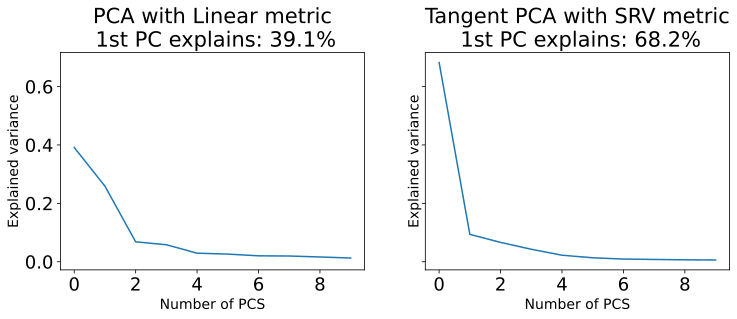

In [23]:
n_components = 10

pcas = {}
pcas["Linear"] = PCA(n_components=n_components).fit(cells_flat)
pcas["SRV"] = TangentPCA(n_components=n_components, metric=SRV_METRIC).fit(cell_shapes)

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

for i, metric_name in enumerate(["Linear", "SRV"]):
    axs[i].plot(pcas[metric_name].explained_variance_ratio_)
    axs[i].set_xlabel("Number of PCS")
    axs[i].set_ylabel("Explained variance")
    tangent = ""
    if metric_name == "SRV":
        tangent = "Tangent "
    first_pc_explains = 100*sum(pcas[metric_name].explained_variance_ratio_[:1])
    axs[i].set_title(f"{tangent}PCA with {metric_name} metric\n 1st PC explains: {first_pc_explains:.1f}%")

SAVEFIG = True
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_pca_explained_variance.svg"))

We observe that the first principal components of the tangent PCA using the SRV metric captures a larger portion of the variance.

The first two components of the PCA with the Linear metric captures the following variance ratio:

In [24]:
sum(pcas["Linear"].explained_variance_ratio_[:1])

0.3913485951366246

The first two components of the tangent PCA with the SRV metric captures the following variance ratio:

In [25]:
sum(pcas["SRV"].explained_variance_ratio_[:1])

0.682442747615715

We explore the projections of the cell data on the two principal components of each PCA.

The projections on the PCA of the SRV metric are more informative, as they have captured more variance.

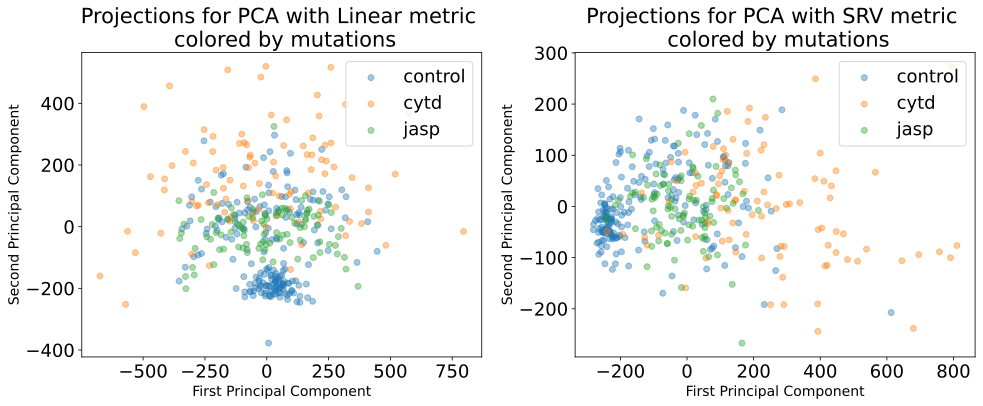

In [26]:
cell_transformed = {}
cell_transformed["Linear"] = pcas["Linear"].fit_transform(cells_flat)
cell_transformed["SRV"] = pcas["SRV"].fit_transform(cell_shapes)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

for i, metric_name in enumerate(["Linear", "SRV"]):
    for j, (labels_dict, labels, labels_name) in enumerate(zip(
        [labels_b_dict], [labels_b], [labels_b_name])):
        for i_lab, label in enumerate(np.unique(labels)):
            cell_tr = cell_transformed[metric_name][dists_summary[labels_name] == label]
            axs[i].scatter(
                cell_tr[:, 0],
                cell_tr[:, 1],
                c=[f"C{labels_dict[lab]+2*j}" for lab in labels if lab == label],
                alpha=0.4,
                label=label
            )
            axs[i].set_xlabel("First Principal Component")
            axs[i].set_ylabel("Second Principal Component")
            axs[i].set_title(
                f"Projections for PCA with {metric_name} metric \n colored by {labels_name}")
            axs[i].legend()
plt.tight_layout()
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_pca_projections_2d.svg"))

## Dimension Reduction via MDS

We examine another dimension reduction technique: Multidimensional Scaling (MDS).

MDS relies on computing the (pairwise) distances between any two pairs of cells, which we do first using just in time compilation (jit) to speed up the computations.

In [27]:
def linear_dist(cell1, cell2):
    return np.linalg.norm(cell1 - cell2) / n_sampling_points

def srv_dist(cell1, cell2):
    return SRV_METRIC.dist(cell1, cell2) / n_sampling_points

@jit(nopython=False, forceobj=True)
def parallel_dist(cells, dist_fun):
    pairwise_dists = np.zeros((n_cells, n_cells))
    for i in prange(n_cells):
        for j in prange(i + 1, n_cells):
            pairwise_dists[i, j] = dist_fun(cells[i], cells[j]) / n_sampling_points
    pairwise_dists += pairwise_dists.T
    return pairwise_dists


In [28]:
pairwise_dists = parallel_dist(cells, dist_fun=linear_dist)

INFO: finding looplift candidates


In [29]:
# This takes 7min
pairwise_srv_dists = parallel_dist(cells, dist_fun=srv_dist)

### Plot in 2D

In [59]:
mds = {}
pos = {}

mds["Linear"] = manifold.MDS(n_components=2, random_state=1, dissimilarity="precomputed")
pos["Linear"] = mds["Linear"].fit(pairwise_dists).embedding_
print("the stress for Linear model is:", mds["Linear"].stress_)

mds["SRV"] = manifold.MDS(n_components=2, random_state=1, dissimilarity="precomputed")
pos["SRV"] = mds["SRV"].fit(pairwise_srv_dists).embedding_
print("the stress for SRV model is:", mds["SRV"].stress_)


the stress for Linear model is: 3.6965693174191454
the stress for SRV model is: 0.061448733496545616


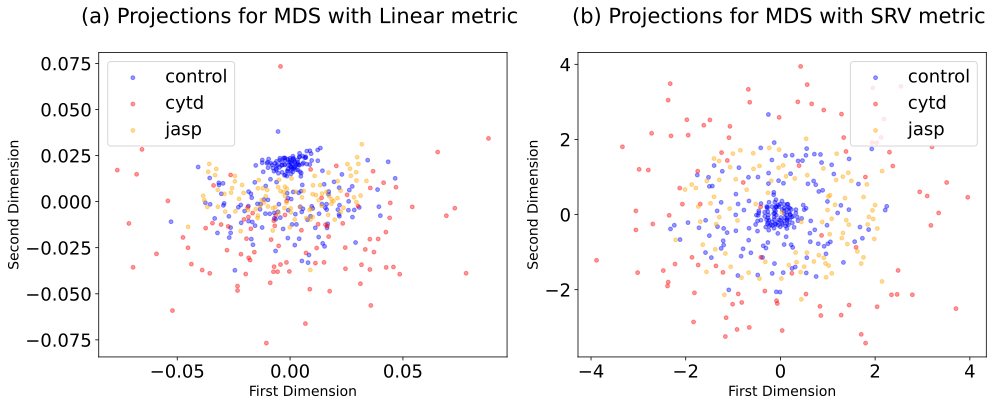

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

color_encoding = {"control": "blue", "cytd": "red", "jasp": "orange"}

title_nums = ['(a)', '(b)']
for i, metric_name in enumerate(["Linear", "SRV"]):
    for j, (labels_dict, labels, labels_name) in enumerate(zip(
        [labels_b_dict], [labels_b], [labels_b_name])):
        for i_lab, label in enumerate(np.unique(labels)):
            position = pos[metric_name][dists_summary[labels_name] == label]
            if metric_name == "SRV":
                position = 1000 * position  # rescaling axis for display purposes
            axs[i].scatter(
                position[:, 0],
                position[:, 1],
                c=[color_encoding[label] for lab in labels if lab == label],
                alpha=0.4,
                s=15,
                label=label,
            )

            axs[i].set_xlabel("First Dimension")
            axs[i].set_ylabel("Second Dimension")
            axs[i].set_title(
                f"{title_nums[i]} Projections for MDS with {metric_name} metric \n")
            axs[i].legend()
plt.tight_layout()
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_{cell_type}_mds_projections_2d.pdf"))

In [36]:
# MDS to estimate the dimension (AIC)
# plot in 3d?
# keep the same color coding with the histogram
# R squared 

### Plot in 3D

In [54]:
%matplotlib widget
  
# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [55]:
mds = {}
pos = {}

n_components = 3

mds["Linear"] = manifold.MDS(n_components=n_components, random_state=1, dissimilarity="precomputed")
pos["Linear"] = mds["Linear"].fit(pairwise_dists).embedding_

mds["SRV"] = manifold.MDS(n_components=n_components, random_state=1, dissimilarity="precomputed")
pos["SRV"] = mds["SRV"].fit(pairwise_srv_dists).embedding_

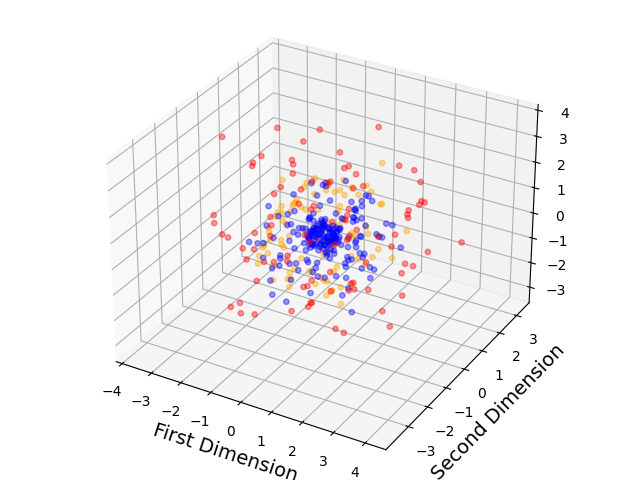

In [56]:
fig = plt.figure()
ax = Axes3D(fig)
metric_name = "SRV"

for j, (labels_dict, labels, labels_name) in enumerate(zip(
    [labels_b_dict], [labels_b], [labels_b_name])):
    for i_lab, label in enumerate(np.unique(labels)):
        position = pos[metric_name][dists_summary[labels_name] == label]
        if metric_name == "SRV":
            position = 1000 * position  # rescaling axis for display purposes
        ax.scatter(
            position[:, 0],
            position[:, 1],
            position[:, 2],
            c=[color_encoding[label] for lab in labels if lab == label],
            alpha=0.4,
            s=15,
            label=label,
        )

        ax.set_xlabel("First Dimension")
        ax.set_ylabel("Second Dimension")
        ax.set_title(
            f"{title_nums[i]} Projections for MDS with {metric_name} metric \n")
        # ax.legend()

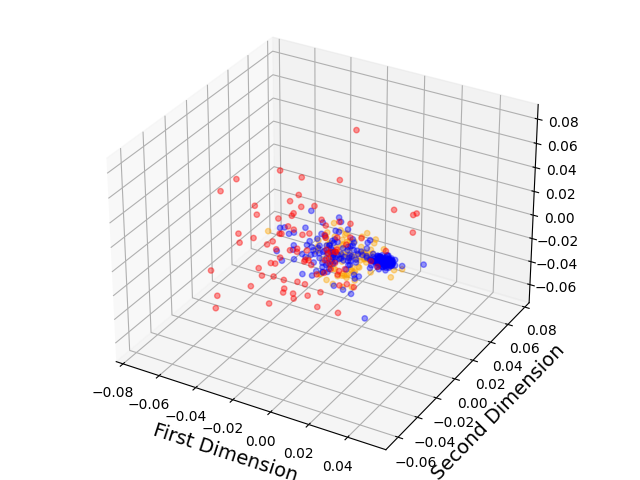

In [57]:
fig = plt.figure()
ax = Axes3D(fig)
metric_name = "Linear"

for j, (labels_dict, labels, labels_name) in enumerate(zip(
    [labels_b_dict], [labels_b], [labels_b_name])):
    for i_lab, label in enumerate(np.unique(labels)):
        position = pos[metric_name][dists_summary[labels_name] == label]
        if metric_name == "SRV":
            position = 1000 * position  # rescaling axis for display purposes
        ax.scatter(
            position[:, 0],
            position[:, 1],
            position[:, 2],
            c=[color_encoding[label] for lab in labels if lab == label],
            alpha=0.4,
            s=15,
            label=label,
        )

        ax.set_xlabel("First Dimension")
        ax.set_ylabel("Second Dimension")
        ax.set_title(
            f"{title_nums[i]} Projections for MDS with {metric_name} metric \n")
        # ax.legend()

### Estimate dimension using MDS

### Quantify the qualify of MDS by R squared